### Project 3: Subreddit NLP Prediction

![Image of a house made of books](bookhouse.jpg)

#### Problem Statement

**Business Context**:

Book House publishing is a children's book publiser. They're looking to rebrand their image and publish books that appeal to a larger, more mature audience. Two very popular genres are Horror Literature and Fantasy Literature. Book House Publishing wants to better understand these audiences and how to appeal to readers of these genres. 

Reddit is a popular social media platform where users can submit content, engage in discussions and participate in communities of like-minded individualts know as "subreddits." Reddit is also know as "the front page of the internet" because of the vast and diverse collection of user-generated content. For this reason its a good place to scrape data for this research that can be used for trageted marketing.

##### Library imports

In [44]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from textblob import TextBlob
from wordcloud import WordCloud
import pickle

# model building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import xgboost as xgb


from sklearn import set_config
set_config(display='diagram')

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer

# model scoring
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score


import warnings
# suppress warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer



from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


In [3]:
# pip install wordcloud

##### Read in the data

In [4]:
sub = pd.read_csv('../data/subreddits.csv')

In [5]:
# drop the first column
sub.drop(sub.columns[0], axis=1, inplace=True)

#### EDA Section

In [6]:
sub.head()

,created_utc,title,self_text,subreddit
0,1.511335e+09,Help the fight for net neutrality!,no_text,0
1,1.519578e+09,"Author Terry Goodkind shames his own cover, ar...",no_text,0
2,1.606914e+09,Elliot Page Will Continue to Star in 'Umbrella...,no_text,0
3,1.630597e+09,The Wheel of Time - Official Teaser Trailer,no_text,0
4,1.612284e+09,"GRRM latest update: ""I wrote hundreds and hund...",no_text,0


In [7]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3928 entries, 0 to 3927
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   created_utc  3928 non-null   float64
 1   title        3928 non-null   object 
 2   self_text    3928 non-null   object 
 3   subreddit    3928 non-null   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 122.9+ KB


### Title Column EDA

In [8]:
# average length of titles in terms of words
avg_title_length = sub['title'].apply(lambda x: len(x.split())).mean()
avg_title_length

10.212321792260692

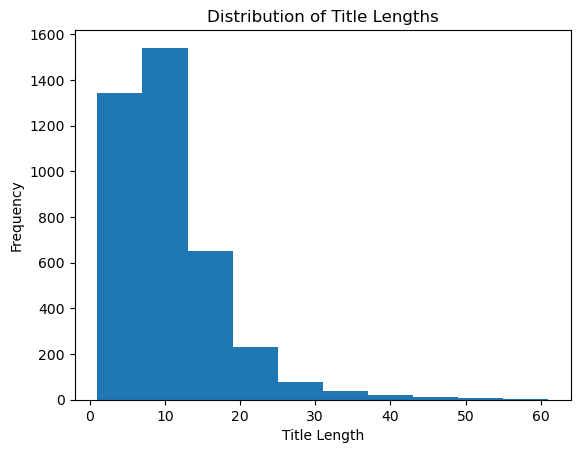

In [9]:
# list of title lengths
title_lengths = sub['title'].apply(lambda x: len(x.split()))

# distribution of title lengths
plt.hist(title_lengths)
plt.xlabel('Title Length')
plt.ylabel('Frequency')
plt.title('Distribution of Title Lengths')
plt.show()

In [10]:
# average length of titles in terms of characters
avg_title_char_length = sub['title'].apply(len).mean()
avg_title_char_length

59.86863543788187

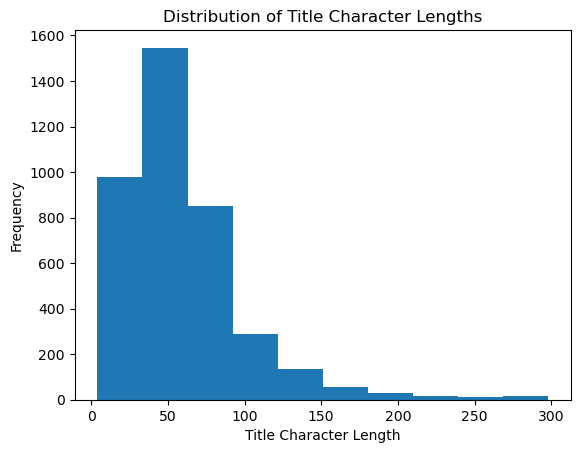

In [11]:
# list of title character lengths
title_char_lengths = sub['title'].apply(len)

# distribution of title character lengths
plt.hist(title_char_lengths)
plt.xlabel('Title Character Length')
plt.ylabel('Frequency')
plt.title('Distribution of Title Character Lengths')
plt.show()

In [12]:
# min and max lengths of titles
min_title_length = sub['title'].apply(len).min()
print(f'Minimum Title Length {min_title_length}')

max_title_length = sub['title'].apply(len).max()
print(f'Maximum Title Length {max_title_length}')

Minimum Title Length 4
Maximum Title Length 298


### Self Text Column EDA

In [13]:
# average length of self-texts in terms of words
avg_self_text_length = sub['self_text'].apply(lambda x: len(x.split())).mean()
avg_self_text_length

198.61761710794298

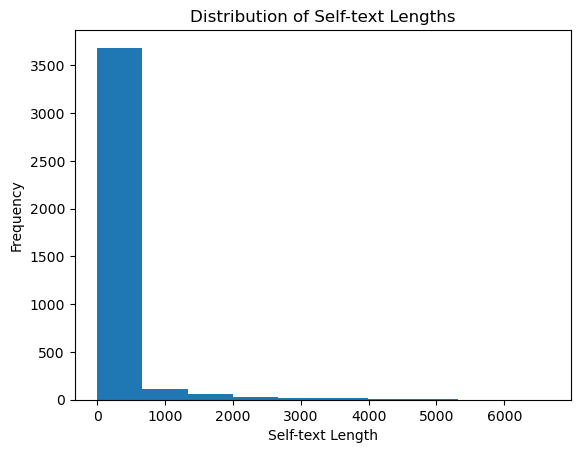

In [14]:
# list of self-text lengths
self_text_lengths = sub['self_text'].apply(lambda x: len(x.split()))

# distribution of self-text lengths
plt.hist(self_text_lengths)
plt.xlabel('Self-text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Self-text Lengths')
plt.show()

In [15]:
# average self-texts in terms of characters
avg_self_text_char_length = sub['self_text'].apply(len).mean()
avg_self_text_char_length

1205.3217922606925

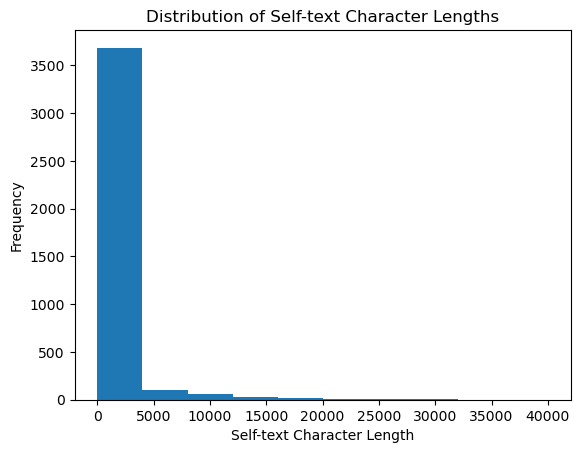

In [16]:
# list of self-text character lengths
self_text_char_lengths = sub['self_text'].apply(len)

# distribution of self-text character lengths
plt.hist(self_text_char_lengths)
plt.xlabel('Self-text Character Length')
plt.ylabel('Frequency')
plt.title('Distribution of Self-text Character Lengths')
plt.show()

In [17]:
# min and max lengths of self-texts
min_self_text_length = sub['self_text'].apply(len).min()
print(f'Minimum Self Text Length {min_self_text_length}')

max_self_text_length = sub['self_text'].apply(len).max()
print(f'Maximum Self Text Length {max_self_text_length}')

Minimum Self Text Length 1
Maximum Self Text Length 40026


In [18]:
# combine 'title' and 'self_text for better predicting & simplified processing
sub['text'] = sub['title'] + ' ' + sub['self_text']

In [19]:
# function to get sentiment polarity from text
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# apply sentiment analysis to the 'text' column
sub['sentiment_polarity'] = sub['text'].apply(get_sentiment)

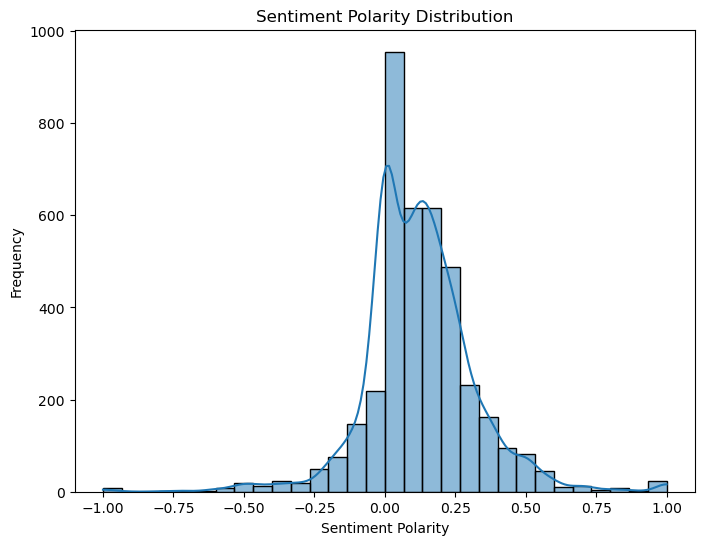

In [20]:
# distribution of sentiment polarity
plt.figure(figsize=(8, 6))
sns.histplot(data=sub, x='sentiment_polarity', bins=30, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

**Observations:**
The overal sentiment for both genres is right skewed. Most comments are neutral or positive in nature 

### Model Buiding Section

#### Pre-Processing w/Spacy

In [21]:
# spaCy English model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [22]:
# additional stop words in order to get more meaningful results back from get_features_out
more_stop = {'read', 'book', 'no_text', 'think', 'know', 'story', 'novel'}


# text preprocessing function
def preprocess_text(text):
    doc = nlp(text)
    # tokenization, lemmatization, lowercase conversion, and removing stopwords and punctuation
    tokens = [token.lemma_.lower() for token in doc if token.lemma_.lower() not in more_stop and not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

In [23]:
# create an instance of the preprocess function
# run the newly combined text column through it
sub['processed_text'] = sub['text'].apply(preprocess_text)

#### Train Test Split

In [24]:
# split data into train/test
X_train, X_test, y_train, y_test = train_test_split(sub['processed_text'], sub['subreddit'], test_size=0.2, random_state=42, shuffle=True)

#### Tfidf Processing

In [25]:
# create tfid vectorizer
tvect = TfidfVectorizer(max_features=5000)

# fit_transform training data
X_train_tvect = tvect.fit_transform(X_train)

# transform the test data
X_test_tvect = tvect.transform(X_test)

In [26]:
# get feature names (words) from the vectorizer
feature_names = tvect.get_feature_names_out()

# create dataframe combining transformed data with subreddit labels
train_df = pd.DataFrame(X_train_tvect.toarray(), columns=feature_names)
train_df['subreddit'] = y_train.reset_index(drop=True)

# group by subreddit and sum for each word
grouped_train = train_df.groupby('subreddit').sum()

# function to get most frequent words for each subreddit value
def get_most_frequent_words(grouped_data):
    most_frequent_words = {}
    for subreddit, data in grouped_data.iterrows():
        top_words = data.nlargest(15)
        most_frequent_words[subreddit] = top_words
    return most_frequent_words

# get most frequent words for each subreddit value
most_frequent_words = get_most_frequent_words(grouped_train)

# print the results for fantasy
print("Most frequent words for subreddit 0:")
print(most_frequent_words[0])

# print results for horror
print("\nMost frequent words for subreddit 1:")
print(most_frequent_words[1])

Most frequent words for subreddit 0:
fantasy      86.792918
series       60.458241
like         49.748452
character    43.799830
time         35.740716
world        31.574656
love         30.735291
art          30.507070
good         28.803490
want         25.185668
look         23.415675
https        22.927411
author       22.756687
magic        22.535572
year         22.476298
Name: 0, dtype: float64

Most frequent words for subreddit 1:
horror            142.204028
like               57.279154
look               45.505959
love               43.391293
good               43.262734
recommendation     37.832223
thank              35.815091
king               30.778066
want               30.267899
house              29.249897
find               28.924760
feel               28.758687
finish             27.526748
scary              26.314606
recommend          26.245879
Name: 1, dtype: float64


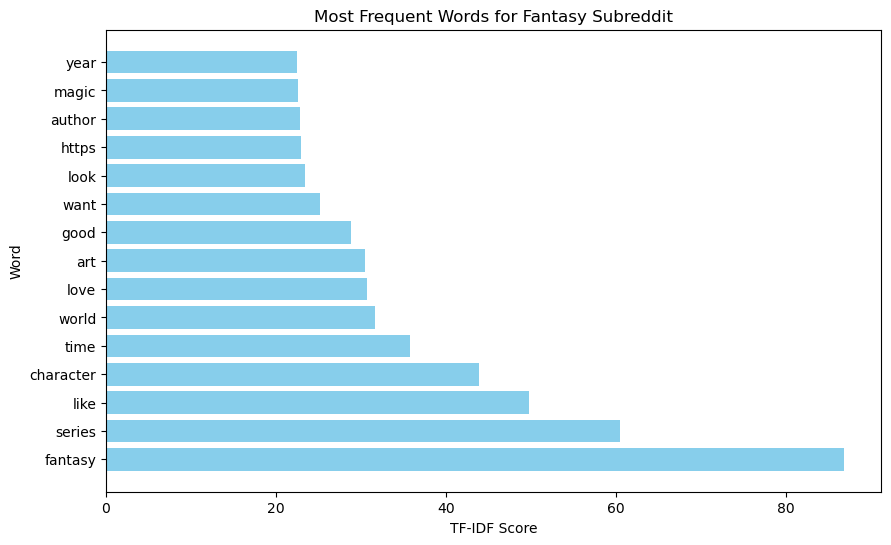

In [27]:
# visual representation of the top 15 most frequent words in the fantasy lit subreddit
plt.figure(figsize=(10, 6))
plt.barh(most_frequent_words[0].index, most_frequent_words[0].values, color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Most Frequent Words for Fantasy Subreddit')
plt.show()

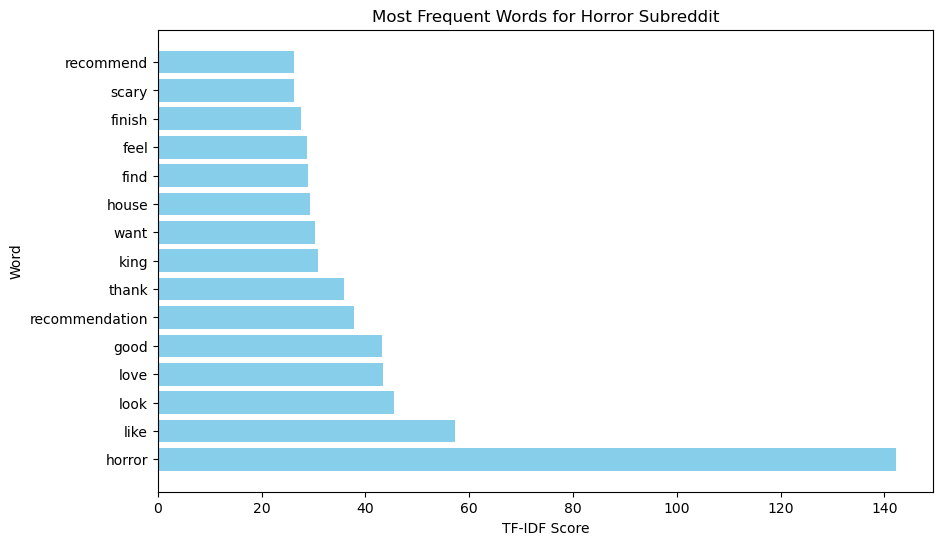

In [28]:
# visual representation of the top 15 most frequent words in the horror lit subreddit
plt.figure(figsize=(10, 6))
plt.barh(most_frequent_words[1].index, most_frequent_words[1].values, color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Most Frequent Words for Horror Subreddit')
plt.show()

## Modeling section

**Assumption:**

My assumption is that using Spacy and TfidfVectorizer to preprocess the data will yeild the best results.

The Experiment section below will challenge this assumption. Stay tuned!

### Model 1: Logistic Regression

In [29]:
# logistic regression model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train_tvect, y_train)

LogisticRegression()

In [47]:
# get predictions
y_pred = logreg.predict(X_test_tvect)

# evaluate performance
log_accuracy = accuracy_score(y_test, y_pred)
log_precision = precision_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
log_f1 = f1_score(y_test, y_pred)

print("Accuracy:", log_accuracy)
print("Precision:", log_precision)
print("Recall:", log_recall)
print("F1-score:", log_f1)

Accuracy: 0.9351145038167938
Precision: 0.9369627507163324
Recall: 0.9185393258426966
F1-score: 0.9276595744680851


### Model: 2 Decision Tree

In [48]:
# Decision Tree model
dtree = DecisionTreeClassifier()

# fit model
dtree.fit(X_train_tvect, y_train)

# get predictions
y_pred = dtree.predict(X_test_tvect)

# evaluate performance
dtree_accuracy = accuracy_score(y_test, y_pred)
dtree_precision = precision_score(y_test, y_pred)
dtree_recall = recall_score(y_test, y_pred)
dtree_f1 = f1_score(y_test, y_pred)

print("Accuracy:", dtree_accuracy)
print("Precision:", dtree_precision)
print("Recall:", dtree_recall)
print("F1-score:", dtree_f1)

Accuracy: 0.8753180661577609
Precision: 0.837696335078534
Recall: 0.898876404494382
F1-score: 0.8672086720867208


### Model 3: Random Forest

In [32]:
# Random Forest model
rf = RandomForestClassifier()
# fit model
rf.fit(X_train_tvect, y_train)

# get predictions
y_pred = rf.predict(X_test_tvect)

# Evaluate model performance
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", rf_accuracy)

Accuracy: 0.9300254452926209


### Model 4: SVC

In [33]:
# SVM model
svm_model = SVC()

# fit model
svm_model.fit(X_train_tvect, y_train)

# get predictions
svm_predictions = svm_model.predict(X_test_tvect)

# evaluate performance
svc_accuracy = accuracy_score(y_test, svm_predictions)
print("Accuracy:", svc_accuracy)

Accuracy: 0.9414758269720102


### Model 5: XGBoost

In [34]:
# XGBoost model
xgb_model = xgb.XGBClassifier()

# fit model
xgb_model.fit(X_train_tvect, y_train)

# get predictions
xgb_predictions = xgb_model.predict(X_test_tvect)

# evaluate performance
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("Accuracy:", xgb_accuracy)

Accuracy: 0.9211195928753181


### Model 6: MultinomialNB

In [35]:
# Naive Bayes model
nb_model = MultinomialNB()

# fit model
nb_model.fit(X_train_tvect, y_train)

# get predictions
nb_predictions = nb_model.predict(X_test_tvect)

# evaluate performance
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Accuracy:", nb_accuracy)

Accuracy: 0.9122137404580153


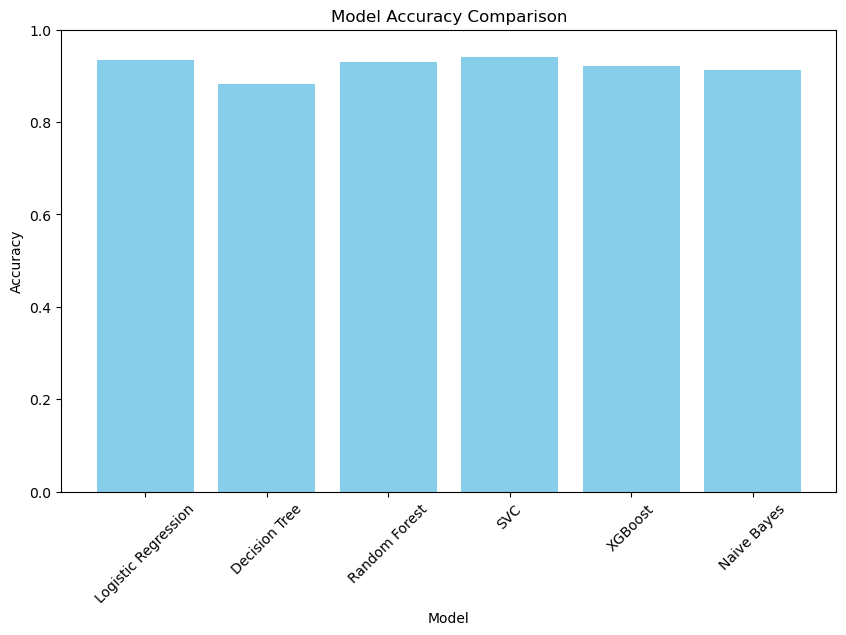

In [36]:
# model performance visualization
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVC', 'XGBoost', 'Naive Bayes']

# model accuracies
accuracies = [log_accuracy, dtree_accuracy, rf_accuracy, svc_accuracy, xgb_accuracy, nb_accuracy]

# create bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # set y-axis limit to ensure accuracy values are visible
plt.xticks(rotation=45)  # better readability
plt.show()

## Experiment Section

I was curious to see if my assumption for the previous models was correct or if more hypertuning would improve my model scores. So I ran the models again below, but with hypertuning and grid search.

**Disclosure:**

I was also curious about how/if I could somewhat automate/streamline the proccess/code. I gave chat gpt my individual models above and asked it how I could build them altogether. The code below isn't mine, it was what chatgpt gave me in response.

I'm running it for fun and learning purposes and as a comparision to my previous code.

In [37]:
# split X and y
X = sub['text']
y = sub['subreddit']

In [38]:
# split data into train/test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle=True)

In [40]:
# Models and their parameter grids for hyperparameter tuning
models = {
    'Logistic Regression': (LogisticRegression(), {'C': [0.1, 1.0, 10.0]}),
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [10, 20]}),
    'Random Forest': (RandomForestClassifier(), {'n_estimators': [50, 100, 200]}),
    'SVM': (SVC(), {'C': [0.1, 1.0, 10.0], 'kernel': ['linear', 'rbf']}),
    'GBM': (GradientBoostingClassifier(), {'learning_rate': [0.1, 0.01], 'n_estimators': [50, 100]}),
    'Naive Bayes': (MultinomialNB(), {'alpha': [0.1, 1.0, 10.0]}),
    'kNN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    'Neural Network': (MLPClassifier(), {'hidden_layer_sizes': [(100,), (50, 50)], 'alpha': [0.0001, 0.001]})
}

# Function to build and evaluate models
def build_and_evaluate_model(model_name, model, parameters, vectorizer_type):
    # Define the pipeline with vectorizer and classifier
    if vectorizer_type == 'CountVectorizer':
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('classifier', model)
        ])
    elif vectorizer_type == 'TfidfVectorizer':
        pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', model)
        ])

    # Separate parameters for vectorizer and classifier
    vectorizer_params = {k: v for k, v in parameters.items() if k.startswith('vectorizer__')}
    classifier_params = {k: v for k, v in parameters.items() if k.startswith('classifier__')}

    # Perform grid search to find the best parameters
    grid_search = GridSearchCV(pipeline, {**vectorizer_params, **classifier_params}, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Save trained model to pickle file
    save_model_to_pickle(grid_search.best_estimator_, f"{model_name}_{vectorizer_type}_model.pkl")

    # Make predictions
    y_pred = grid_search.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Extract feature names
    feature_names = grid_search.best_estimator_.named_steps['vectorizer'].get_feature_names_out()

    return accuracy, report, feature_names

# # Function to save model to pickle file
def save_model_to_pickle(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

# Function to load model from pickle file
def load_model_from_pickle(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)
    return model

# Iterate over models, build and evaluate each model with CountVectorizer and TfidfVectorizer
results = {}
for model_name, (model, parameters) in models.items():
    for vectorizer_type in ['CountVectorizer', 'TfidfVectorizer']:
        accuracy, report, feature_names = build_and_evaluate_model(model_name, model, parameters, vectorizer_type)
        results[(model_name, vectorizer_type)] = {'accuracy': accuracy, 'report': report, 'feature_names': feature_names}

# Print results
for (model_name, vectorizer_type), result in results.items():
    print(f"Model: {model_name}, Vectorizer: {vectorizer_type}")
    print(f"Accuracy: {result['accuracy']}")
    print("Classification Report:")
    print(result['report'])
    print(f"Number of features: {len(result['feature_names'])}\n")

/Users/tanyaseegmiller/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tanyaseegmiller/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Model: Logistic Regression, Vectorizer: CountVectorizer
Accuracy: 0.9325699745547074
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       430
           1       0.91      0.94      0.93       356

    accuracy                           0.93       786
   macro avg       0.93      0.93      0.93       786
weighted avg       0.93      0.93      0.93       786

Number of features: 31573

Model: Logistic Regression, Vectorizer: TfidfVectorizer
Accuracy: 0.9325699745547074
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       430
           1       0.90      0.96      0.93       356

    accuracy                           0.93       786
   macro avg       0.93      0.93      0.93       786
weighted avg       0.93      0.93      0.93       786

Number of features: 31573

Model: Decision Tree, Vectorizer: CountVectorizer
Accuracy: 0.88931297709923

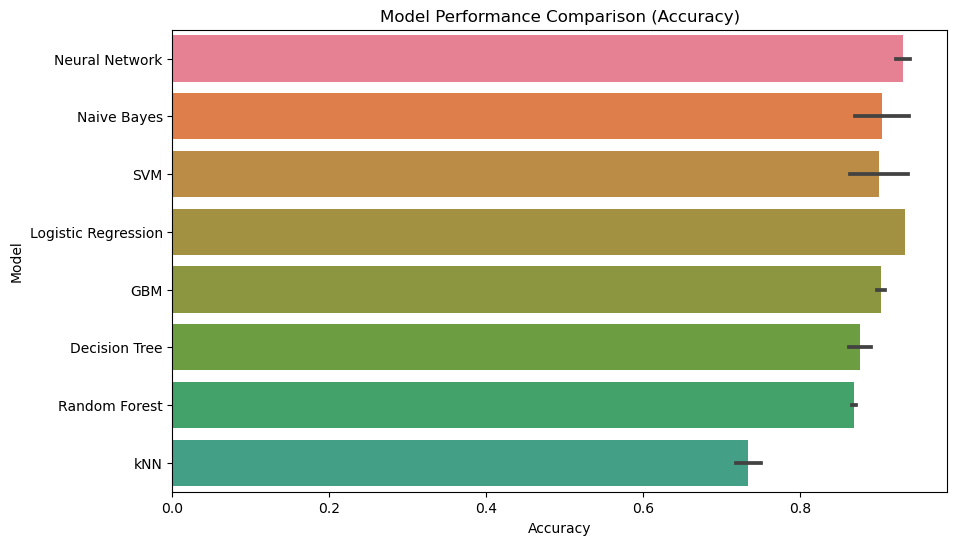

In [41]:
# models and their accuracies
model_names = [name[0] for name in results.keys()]
accuracies = [result['accuracy'] for result in results.values()]

# create a DataFrame from the model names and accuracies
accuracy_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies})

# sort in descending order
accuracy_df = accuracy_df.sort_values(by='Accuracy', ascending=False)

# make it pretty
color_palette = sns.color_palette('husl', len(model_names))

# bar plot of accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=accuracy_df, palette=color_palette)
plt.title('Model Performance Comparison (Accuracy)')
plt.xlabel('Accuracy')
plt.show()

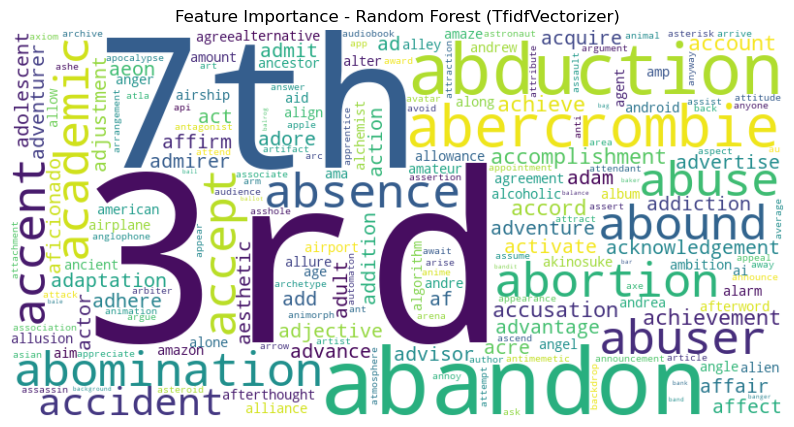

In [42]:
# word cloud for fun
# feature names and their importance scores
feature_importance = results[('Random Forest', 'CountVectorizer')]['feature_names']
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(feature_importance))

# plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Feature Importance - Random Forest (TfidfVectorizer)')
plt.show()

**Conclusions**
SpaCy lemmatization was as effective as I thought it would be on this project.
In most models TfidfVectorizer had the greatest impact on improving the model scores, though not in all. Also, to achieve the best feature selection and prediction, robust gridsearching wasn't necessary. 

Both Fantasy Literature and Horror Liturature subreddits had positive sentiment with respect to their preferred genre. Positive descripters were a key factor in every model correctly identifying which comment came from which subreddit. 

**Recommendations**
We have several trained models predicting at 94% accuracy. From here, I would suggest, as it pertains to the problem statement, that either genre would be favorable for Book House to branch into. Both genres have robust fan bases, with positive sentimentality towards their preferred genre.

**Best Models**

- Accuracy: Logistic Regress w/CountVectorizer and TfidfVectorizer: 94%
- Precision: NN w/ CountVectorizer & Naive Bayes w/ CountVectorizer: 94%
- Best overall: Naive Bayes w/CountVectorizer 